In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, memory=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - memory - 1):
        a = dataset[i:(i + memory), 0]
        dataX.append(a)
        dataY.append(dataset[i + memory, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
# Loading data with column date as index
# Folder
dataset_folder="dataset"

# Dataset file
# It's very easy download from Yahoo finantial if you want data updated.
filename="AMZN_2006-01-01_to_2018-01-01.csv"
#filename="GOOGL_2006-01-01_to_2018-01-01.csv"
#filename="IBM_2006-01-01_to_2018-01-01.csv"

dataset = pd.read_csv(dataset_folder + "/" + filename, index_col='Date', parse_dates=True)

In [4]:
# Preview the data
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [5]:
# Searching null values.
dataset.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [6]:
# Replacing null values by its mean value.
dataset.replace(np.NAN, dataset.mean(), inplace=True)

In [7]:
# Forecast between these dates
test_start_date = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')
test_end_date = datetime.datetime.strptime('2017-12-31', '%Y-%m-%d')

In [8]:
# Column to be selected
column=1
data_set = dataset.iloc[:, column:column+1]

In [9]:
data_set

,High
Date,
2006-01-03,47.85
2006-01-04,47.73
2006-01-05,48.20
2006-01-06,48.58
2006-01-09,47.10
...,...
2017-12-22,1174.62
2017-12-26,1178.32
2017-12-27,1187.29


In [10]:
# We split the data into training and test sets
training_set = data_set[:test_start_date - datetime.timedelta(1)]
test_set = data_set[test_start_date:test_end_date]

In [11]:
# Normalize between 0,1 the datasets
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_set)
data_set_scaled = scaler.transform(data_set)
training_set_scaled = scaler.transform(training_set)
test_set_scaled = scaler.transform(test_set)

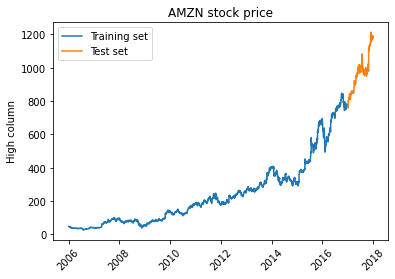

In [12]:
# Plotting training and test sets
stock = filename.split("_",1)[0]
plt.plot(training_set)
plt.plot(test_set)
plt.title(stock + ' stock price')
plt.legend(['Training set', 'Test set'])
plt.ylabel(dataset.columns[column] + ' column')
plt.xticks(rotation=45)
plt.show()

In [13]:
# We define the memory for our LSTM
memory = 60
X_train, y_train = create_dataset(training_set_scaled, memory)

In [14]:
# Checking the data shaping
print(X_train.shape)
print('{:.8f}'.format(y_train[0]))
print(data_set_scaled[memory])
# Last digit must be the same
print(X_train[1,:])

(2707, 60)
0.00892925
[0.00892925]
[0.01805224 0.01844816 0.01876827 0.01752154 0.01722671 0.01634221
 0.01582836 0.01562618 0.01517972 0.01540717 0.01595471 0.01521342
 0.01554195 0.01527238 0.01530608 0.01556722 0.01593787 0.01656965
 0.01592944 0.0154914  0.01494386 0.01027706 0.01014228 0.01002434
 0.0101844  0.01069825 0.01029391 0.01020967 0.01026864 0.01093412
 0.01154063 0.01101836 0.01079091 0.01078249 0.01048765 0.01020125
 0.01051293 0.00993168 0.00959473 0.00901349 0.00971266 0.00950207
 0.00936729 0.00940941 0.00897979 0.0085923  0.00870181 0.00901349
 0.00901349 0.00934202 0.00899664 0.00924093 0.00878604 0.00862599
 0.00845751 0.00827219 0.00788469 0.00818795 0.00885343 0.00892925]


In [15]:
# Reshape input to be [samples=X_train.shape[0], time steps=X_train.shape[1], features=1].
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [16]:
X_train.shape

(2707, 60, 1)

In [17]:
# Design of the LSTM RNN
# input_shape (batch_size: set up in the fitting phase as batch_size , time_steps, seq_len)

model = Sequential()

# Input layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(memory, 1)))

# Intermediate layers
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))

# Output layer
model.add(Dense(units=1))

# Compiling
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 52,101
Trainable params: 52,101
Non-trainable params: 0
____________________________________________________

In [19]:
# Prepairing the memory for the first value (the last value of the traninig data set).
inputs = data_set_scaled[len(data_set) - len(test_set) - memory:len(data_set) - len(test_set) - 1]

In [ ]:
# Fitting
model.fit(X_train, y_train, epochs=5, batch_size=5)

Epoch 1/5
542/542 [==============================] - 9s 17ms/step - loss: 8.3265e-04
Epoch 2/5
542/542 [==============================] - 9s 17ms/step - loss: 3.2141e-04
Epoch 3/5
323/542 [================>.............] - ETA: 3s - loss: 3.9220e-04

In [ ]:
# We want a large forecast not only one value.
predicted_stock_price = np.array(training_set_scaled[-1])
for i in range(len(test_set)):
    inputs = np.vstack([inputs, predicted_stock_price[i]])
    X_test = np.array(inputs[i:])
    X_test = np.reshape(X_test, (1, X_test.shape[0], 1))
    predicted_stock_price = np.vstack([predicted_stock_price, model.predict(X_test)])

predicted_stock_price = scaler.inverse_transform(predicted_stock_price[1:])

In [ ]:
# Checking the first forecast value vs the first test value.
print(test_set.iloc[0].values)
print(predicted_stock_price[0])

In [ ]:
predicted_set = pd.DataFrame(data=predicted_stock_price, index=dataset[test_start_date:test_end_date].index, columns=[column])

In [ ]:
# Holt-Winters algorithm running
# Each year we have the same periods: summer holidays, Easter, Chrismas...
# We have 252 business days per year.
season=252

df = dataset.resample('B').mean().ffill()
train, test = df[:test_start_date - datetime.timedelta(1)].iloc[:,column], \
              df[test_start_date:test_end_date].iloc[:,column]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=season).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

In [ ]:
# Plotting the graphs
plt.plot(test_set, color='red', label='Real ' + stock + ' Stock Price')
plt.plot(predicted_set, color='blue', label='LSTM RNN')
plt.plot(pred, color='green', label='Holt-Winters')
plt.title(stock + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
# Evaluating our models with RMSE
rnn_rmse = math.sqrt(mean_squared_error(test_set, predicted_set))
hw_rmse = math.sqrt(mean_squared_error(test, pred))
print("The root mean squared error for RNN is {}.".format(rnn_rmse))
print("The root mean squared error for Holt-Winters is {}.".format(hw_rmse))